In [1]:
import sys

import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import numpy as np
import datetime as dt
import geopandas as gpd
import dendropy
import csv
from shapely.geometry import Point
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from pyproj import Proj,transform
import tqdm
import pandas as pd
from matplotlib import cm
import matplotlib
import matplotlib.ticker as plticker
import os

csv.field_size_limit(sys.maxsize)


131072

In [2]:
def true_date(date):
    
    year = str(date).split(".")[0]
    decimal = f'0.{str(date).split(".")[1]}'
    
    if year == '2020':
        day_no = float(decimal) * 366
    else:
        day_no = float(decimal) * 365
        
    delta = dt.timedelta(day_no)
    
    start = dt.date(year=int(year), month=1, day=1)
    tr_date = start + delta
    
    return str(tr_date)

def decimal_date(date):
    
    if type(date) == str:
        date = dt.datetime.strptime(date,"%Y-%m-%d").date()
    year = date.year
    if year == 2020:
        div = 366
    else:
        div = 365
    start = dt.date(year=year, month=1, day=1)
    decimal = (date - start).days/div
    
    dec_date = year + decimal
    return dec_date

In [3]:
colours = {
"0_67":"#e2ecf2",
"0_92":"#ffd544",
"0_190":"#fe6362",
"0_322":"#484c7e",
"0_386":"#bbbee9",
"1_51": "#98c1d9",
"2_337": "#293241"  
}

names = {
"0_67":"Lineage IV",
"0_92":"Lineage I",
"0_190":"Lineage II",
"0_322":"Lineage VI",
"0_386":"Lineage VII",
"1_51": "Lineage V",
"2_337": "Lineage III" 
}


In [4]:
def get_roots(int_list, input_dir):
    
    roots = {}
    
    for intro in int_list:
        num_file = intro.split("_")[0]
        lineage = intro.split("_")[1]
        rel_file = f'15K_00{num_file}.median_tree.tsv'
        with open(os.path.join(input_dir,rel_file)) as f:
            data = csv.DictReader(f, delimiter="\t")
            for l in data:
                if l['lineage'] == lineage:
                    roots[intro] = decimal_date(l['tmrca'].split("T")[0])
                    
    return roots

roots = get_roots(list(colours.keys()), "../input_files/median_import_tree/")

In [5]:
def get_most_recent_tips(mrts, input_dir):
    for file in tqdm.tqdm(os.listdir(input_dir)):
        if file.endswith("csv"):
            name = file.strip(".csv")
            dates = []
            with open(os.path.join(input_dir,file)) as f:
                data = csv.DictReader(f)
                for l in data:
                    seq_name = l['name']
                    date = decimal_date(seq_name.split("|")[1])
                    dates.append(date)
                    
            mrt = max(dates)
            mrts[name] = mrt
    return mrts
          
mrts = {}
mrts = get_most_recent_tips(mrts,"../input_files/large_lineages/")

100%|██████████| 21/21 [00:00<00:00, 26.59it/s]


In [9]:
most_recent_obs = 2021.452
for k,v in roots.items():
    print(k,names[k], true_date(v))
    


0_67 Lineage IV 2021-04-15
0_92 Lineage I 2021-03-09
0_190 Lineage II 2021-04-02
0_322 Lineage VI 2021-04-18
0_386 Lineage VII 2021-04-23
1_51 Lineage V 2021-03-16
2_337 Lineage III 2021-02-28


## Plot skygrids

In [11]:
path = ##path to data

#Specified in BEAST XML
logpop_length = 26
skygrid_cutoff = 0.5

# logpop_length_2 = 77 
# skygrid_cutoff_2 = 0.75

#Most recently sampled sequence
most_recent_obs = 2021.45

#This is not always the same, it depends on the number of parameters, so double check this in the log file.
#Index of first logpop column
start = 4

# tmrca_col = 5

#This can be changed, but usually 10% is about right
burn_in = 10 #in percent

In [8]:
#Get the rows of the log file that contains the logpop measurements
def skygrid_prep(log_file, burn_in):

    count = 0

    with open(log_file) as f:
        next(f)
        next(f)
        next(f)
        next(f)
        next(f)
        for l in f:
            count += 1
            cols = l.strip("\n").split("\t")
            width = len(cols)

    length = count

    dimensions = (length, width)

    end_iteration = dimensions[0]
    
    if burn_in != 0:
        begin_iteration = int(round(end_iteration/burn_in, 0))
    else:
        begin_iteration = 0
    
    return end_iteration, begin_iteration

#Get the columns of the log file that contains logpops
def get_cols(log_file, end_iteration, begin_iteration, logpop_length):

    count2 = 0
    count3 = 0
    skygrid = defaultdict(list)

    skygrid_cols = [i for i in range(1,logpop_length + 1)]
    rows = []

    with open(log_file) as f:
        next(f)
        next(f)
        next(f)
        next(f)
        next(f)
        for l in f:
            count2 += 1
            if count2 >= begin_iteration and count2 <= end_iteration:
                count3 += 1
                cols = l.strip("\n").split("\t")
                cols_wanted = cols[start:start+logpop_length+1]
                #print(len(cols_wanted))
                #if count2 == begin_iteration + 2 or count2 == begin_iteration + 3:
                for item in skygrid_cols:
                    #print(item)
                    skygrid[item].append(float(cols_wanted[item]))
                #rows.append(cols_wanted)

    #print(count3)
     
    return skygrid

#Pull out the logpop measurements from the logfile
def log_pops(skygrid):

    mean_dict = {}
    lower_dict = {}
    upper_dict = {}

    for key, value in skygrid.items():
        mean_dict[key] = (sum(value)/len(value))
        lower_dict[key] = np.percentile(value, 2.5)
        upper_dict[key] = np.percentile(value, 97.5)
        
    mean_list = []
    lower_list = []
    upper_list = []

    for value in mean_dict.values():
        mean_list.append(value)
    for value in lower_dict.values():
        lower_list.append(value)
    for value in upper_dict.values():
        upper_list.append(value)

    revmean = list(reversed(mean_list))
    revlower = list(reversed(lower_list))
    revupper = list(reversed(upper_list))

    return revmean, revlower, revupper, mean_list, lower_list, upper_list

#Combining all - will return the mean logpop at each timepoint (minus burn-in), with lower and upper bounds, forwards in time

def get_pop_sizes(log_file, burn_in, logpop_length):
    
    step1 = skygrid_prep(log_file, burn_in)
    
    step2 = get_cols(log_file, step1[0], step1[1], logpop_length)
    
    step3 = log_pops(step2)
    
    return step3

#Define the gridpoints from the skygrid 
def get_gridpoints(end_time, skygrid_cutoff, logpop_length):
    
    begin_time = end_time - skygrid_cutoff

    total_time = end_time - begin_time

    gridpoint_intervals = total_time/logpop_length
    
    print(begin_time)
    print(total_time)
    
    gridpoints = []
    new = 0

    for i in range(logpop_length):
        new += gridpoint_intervals
        gridpoints.append(new)

    #print(gridpoints)
    revtimes = list(reversed(gridpoints))

    times_in_years = [end_time - i for i in revtimes]
#     times_in_years.append(end_time)
    
    return times_in_years, revtimes, begin_time, end_time

In [9]:
def make_skygrid_params(log_file, burn_in, logpop_length, skygrid_cutoff, most_recent_obs, lower_root_estimate):

    revmean, revlower, revupper,means,lowers,uppers = get_pop_sizes(log_file, burn_in, logpop_length)

    times_in_years, revtimes, begin_time, end_time = get_gridpoints(most_recent_obs, skygrid_cutoff, logpop_length)
    
    for count, gp in enumerate(times_in_years):
        if gp > lower_root_estimate:
            print(count, gp)
            print(count-1,times_in_years[count-1])
            relevant_index = count-1
            break
    
    x = times_in_years[relevant_index:]
    y = revmean[relevant_index:]
    error_lower = revlower[relevant_index:]
    error_upper = revupper[relevant_index:]
    
    return x,y,error_lower,error_upper



In [26]:

x_1, y_1, l_error_1, u_error_1 = make_skygrid_params(os.path.join(path,'0_67_skygrid.log'), burn_in, logpop_length,skygrid_cutoff, most_recent_obs,roots["0_67"])
x_2, y_2, l_error_2, u_error_2 = make_skygrid_params(os.path.join(path,'0_92_skygrid.log'), burn_in, logpop_length,skygrid_cutoff, most_recent_obs,roots["0_92"])
x_3, y_3, l_error_3, u_error_3 = make_skygrid_params(os.path.join(path,'0_190_skygrid.log'), burn_in, logpop_length,skygrid_cutoff, most_recent_obs,roots["0_190"])
x_4, y_4, l_error_4, u_error_4 = make_skygrid_params(os.path.join(path,'0_322_skygrid.log'), burn_in, logpop_length,skygrid_cutoff, most_recent_obs,roots["0_322"])
x_5, y_5, l_error_5, u_error_5 = make_skygrid_params(os.path.join(path,'0_386_skygrid.log'), burn_in, logpop_length,skygrid_cutoff, most_recent_obs,roots["0_386"])
x_6, y_6, l_error_6, u_error_6 = make_skygrid_params(os.path.join(path,'1_51_skygrid.log'), burn_in, logpop_length,skygrid_cutoff, most_recent_obs,roots["1_51"])
x_7, y_7, l_error_7, u_error_7 = make_skygrid_params(os.path.join(path,'2_337_skygrid.log'), burn_in, logpop_length,skygrid_cutoff, most_recent_obs,roots["2_337"])




2020.952
0.5
18 2021.2981538461538
17 2021.278923076923
2020.952
0.5
13 2021.202
12 2021.1827692307693
2020.952
0.5
16 2021.2596923076924
15 2021.2404615384614
2020.952
0.5
18 2021.2981538461538
17 2021.278923076923
2020.952
0.5
19 2021.3173846153845
18 2021.2981538461538
2020.952
0.5
14 2021.2212307692307
13 2021.202
2020.952
0.5
11 2021.1635384615386
10 2021.1443076923076


/var/folders/pd/bjtp4xt916vfpszlps7rr5_c0000gn/T/ipykernel_7748/1559124669.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


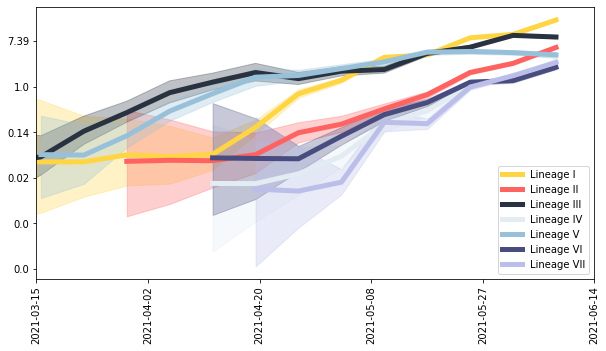

In [31]:
plt.rcParams.update({'font.size':10})
fig,ax = plt.subplots(1,1, figsize=(10,5))

begin_time = 2021.2
end_time = 2021.45

ax.plot(x_2,y_2,color=colours["0_92"], linewidth=5, alpha=1, label=names["0_92"]) 
ax.fill_between(x_2,l_error_2,u_error_2, color=colours["0_92"], alpha=0.3)

ax.plot(x_3,y_3,color=colours["0_190"], linewidth=5, alpha=1, label=names["0_190"]) 
ax.fill_between(x_3,l_error_3,u_error_3, color=colours["0_190"], alpha=0.3)

ax.plot(x_7,y_7,color=colours["2_337"], linewidth=5, alpha=1, label=names['2_337']) 
ax.fill_between(x_7,l_error_7,u_error_7, color=colours['2_337'], alpha=0.3)


ax.plot(x_1,y_1,color=colours["0_67"], linewidth=5, alpha=1, label=names["0_67"]) 
ax.fill_between(x_1,l_error_1,u_error_1, color=colours["0_67"], alpha=0.3)

ax.plot(x_6,y_6,color=colours["1_51"], linewidth=5, alpha=1, label=names['1_51']) 
ax.fill_between(x_6,l_error_6,u_error_6, color=colours['1_51'], alpha=0.3)


ax.plot(x_4,y_4,color=colours["0_322"], linewidth=5, alpha=1, label=names['0_322']) 
ax.fill_between(x_4,l_error_4,u_error_4, color=colours["0_322"], alpha=0.3)

ax.plot(x_5,y_5,color=colours["0_386"], linewidth=5, alpha=1, label=names['0_386']) 
ax.fill_between(x_5,l_error_5,u_error_5, color=colours['0_386'], alpha=0.3)


ax.set_xticks(ticks=ax.get_xticks())
ax.set_xlim(begin_time, end_time)

xticks = []
for i in ax.get_xticks():
    xticks.append(true_date(i))

ax.set_xticklabels(xticks,rotation=90) 
yticks = []
for i in ax.get_yticks():
    yticks.append(round(np.exp(i),2))
ax.set_yticklabels(yticks) 

ax.legend(loc='lower right')

plt.savefig("../figures/big_lineage_skygrids.pdf", bbox_inches='tight')
plt.savefig("../figures/big_lineage_skygrids.png", bbox_inches='tight')



plt.show()